In [1]:
import os
os.environ.setdefault("XLA_FLAGS", "--xla_gpu_autotune_level=0")

'--xla_gpu_autotune_level=0'

In [2]:
import jax

jax.config.update("jax_default_matmul_precision", "float32")
jax.config.update("jax_compilation_cache_dir", "jax_xla_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir")

In [3]:
import rioxarray
import xarray
import pandas

import jax.numpy as jnp
import glaunti.ti_model as model
import dataloader.dataloader as dataloader
import core.loss as loss
import core.training as training
import utils.serialise
import utils.logger
import constants

import matplotlib.pyplot as plt
import datetime
import numpy as np
import pyproj
from tqdm import tqdm

In [4]:
dataset_index = dataloader.retrieve_dataset_index()
glacier = dataset_index[dataset_index.name == "Schwarzberg"].iloc[0]

In [5]:
# construct 'baseline' climate

In [6]:
next_xy = dataloader.prefetch_xy(
    glacier["name"], constants.study_period_start_year, 
    retrieve_corrector_predictors=False, 
    retrieve_facies=False,
    numpy=False,
)
t_baseline_list, p_baseline_list = [], []

for year in tqdm(range(constants.study_period_start_year, glacier.max_year + 1)):
    x, y = next_xy.get()
    next_xy = dataloader.prefetch_xy(
        glacier["name"], year + 1, 
        retrieve_corrector_predictors=False, 
        retrieve_facies=False,
        numpy=False,
    )

    if not "annual" in x:
        x["annual"] = {
            "temperature": xarray.concat(
                [x["winter"]["temperature"], x["summer"]["temperature"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
            "precipitation": xarray.concat(
                [x["winter"]["precipitation"], x["summer"]["precipitation"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
        }

    t = x["annual"]["temperature"]
    p = x["annual"]["precipitation"]
    gm = x["outlines"]

    t_baseline_list.append(t)
    p_baseline_list.append(p)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.43it/s]


In [7]:
t_baseline = xarray.concat(t_baseline_list, dim="time", join="exact").sortby("time")
p_baseline = xarray.concat(p_baseline_list, dim="time", join="exact").sortby("time")
t_baseline = t_baseline.groupby("time.month").mean("time", skipna=True) 
p_baseline = p_baseline.groupby("time.month").mean("time", skipna=True)

In [8]:
def align_baseline_to_time(time_da, baseline_month_da):
    months = time_da["time"].dt.month
    return baseline_month_da.sel(month=months).assign_coords(time=time_da["time"])

In [9]:
# run simulation and IG

In [10]:
model_callable = jax.jit(
    jax.remat(
        lambda trainable_params, static_params, x, initial_swe: model.run_model(
            trainable_params, 
            static_params, 
            x, 
            initial_swe=initial_swe, 
            return_series=False, 
        ),
    ),
)
params = model.get_initial_model_parameters()
params = utils.serialise.load_pytree(f"params/a_finetuned_{glacier['name']}.eqx", template=params)
trainable_params, static_params = params

In [11]:
def get_glacier_wide_smb(t, p, gm, swe_or_h, model_callable, trainable_params, static_params):
    x = {
        "temperature": t,
        "precipitation": p,
    }
    smb, swe_or_h = model_callable(trainable_params, static_params, x, swe_or_h)
    glacier_wide_smb = jnp.sum(smb * gm) / jnp.sum(gm)
    return glacier_wide_smb, swe_or_h

In [12]:
def ig(f_smb, t, p, t0, p0, m_steps=100):
    alphas = jnp.linspace(0.0, 1.0, m_steps)
    val_and_grads = jax.value_and_grad(lambda t, p: f_smb(t, p)[0], argnums=(0, 1))

    def grad_at_alpha(a):
        t_a = t0 + a * (t - t0)
        p_a = p0 + a * (p - p0)
        _, (gt, gp) = val_and_grads(t_a, p_a)
        return gt, gp

    gts, gps = jax.vmap(grad_at_alpha)(alphas)
    avg_gt = jnp.mean(gts, axis=0)
    avg_gp = jnp.mean(gps, axis=0)

    ig_t = (t - t0) * avg_gt
    ig_p = (p - p0) * avg_gp
    return ig_t, ig_p

In [13]:
swe_or_h, next_xy = loss.init_swe_or_h(
    trainable_params, static_params, model_callable, glacier["name"], False, False, last_numpy=False
)

smb_results, year_bins, ts, ps, outlines = [], [], [], [], []
ig_ts, ig_ps = [], []

for year in tqdm(range(constants.study_period_start_year, glacier.max_year + 1)):
    x, y = next_xy.get()
    next_xy = dataloader.prefetch_xy(
        glacier["name"], year + 1, 
        retrieve_corrector_predictors=False, 
        retrieve_facies=False,
        numpy=False,
    )

    if not "annual" in x:
        x["annual"] = {
            "temperature": xarray.concat(
                [x["winter"]["temperature"], x["summer"]["temperature"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
            "precipitation": xarray.concat(
                [x["winter"]["precipitation"], x["summer"]["precipitation"]], dim="time", join="exact",
            ).sortby("time").groupby("time").mean("time"),
        }

    year_bins.append((x["annual"]["temperature"]["time"].values[0], x["annual"]["temperature"]["time"].values[-1]))
    ts.append(x["annual"]["temperature"])
    ps.append(x["annual"]["precipitation"])
    outlines.append(x["outlines"])

    t_baseline_aligned = align_baseline_to_time(x["annual"]["temperature"], t_baseline)
    p_baseline_aligned = align_baseline_to_time(x["annual"]["precipitation"], p_baseline)
    t_baseline_aligned_jnp = jnp.array(t_baseline_aligned.data)
    p_baseline_aligned_jnp = jnp.array(p_baseline_aligned.data)
    
    x = dataloader.x_to_raw_numpy(x)
    x.update(x["annual"])
    
    f_smb = lambda t, p: get_glacier_wide_smb(
        t, p, x["outlines"], 
        swe_or_h, model_callable, trainable_params, static_params
    )

    ig_t, ig_p = ig(
        f_smb, x["temperature"], x["precipitation"], t_baseline_aligned_jnp, p_baseline_aligned_jnp, 
    )
    ig_ts.append(ig_t)
    ig_ps.append(ig_p)
    
    smb, swe_or_h = f_smb(x["temperature"], x["precipitation"])
    smb_results.append(np.array(smb))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.27it/s]


In [14]:
# compile results
glacier_t, glacier_p = [], []
glacier_ig_t, glacier_ig_p = [], []


def group(da):
    t = da["time"] 
    month = xarray.DataArray(
        pandas.PeriodIndex(t.values, freq="M"),
        dims="time",
        coords={"time": t}, 
        name="month",
    )

    summed = da.groupby(month).sum(dim="time")
    mean_time = t.groupby(month).mean(dim="time")
    out = (
        summed
        .assign_coords({"time": mean_time})
        .swap_dims({"month": "time"})
        .drop_vars("month")
        .sortby("time")
    )
    return out
    

for t, p, gm, ig_t, ig_p in zip(ts, ps, outlines, ig_ts, ig_ps):
    ig_t_xr = t.copy()
    ig_t_xr.data[...] = ig_t
    ig_t_xr = ig_t_xr.rename("IG_t")
    ig_p_xr = p.copy()
    ig_p_xr.data[...] = ig_p
    ig_p_xr = ig_p_xr.rename("IG_t")
    gm_sum = gm.sum()
    glacier_t.append((t * gm).sum(dim=("x", "y")) / gm_sum)
    glacier_p.append((p * gm).sum(dim=("x", "y")) / gm_sum)
    glacier_ig_t.append(group(ig_t_xr.sum(dim=("x", "y"))))
    glacier_ig_p.append(group(ig_p_xr.sum(dim=("x", "y"))))

glacier_t = xarray.concat(glacier_t, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
glacier_p = xarray.concat(glacier_p, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
glacier_ig_t = xarray.concat(glacier_ig_t, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
glacier_ig_p = xarray.concat(glacier_ig_p, dim="time", join="exact",).sortby("time").groupby("time").mean("time")
    
del ts, ps, ig_ts, ig_ps

In [15]:
# plot the results

In [16]:
import matplotlib.pyplot as plt
import matplotlib_scalebar.scalebar
import matplotlib.lines
import scipy
import json

In [18]:
label_years = [2001, 2003, 2014, 2022]

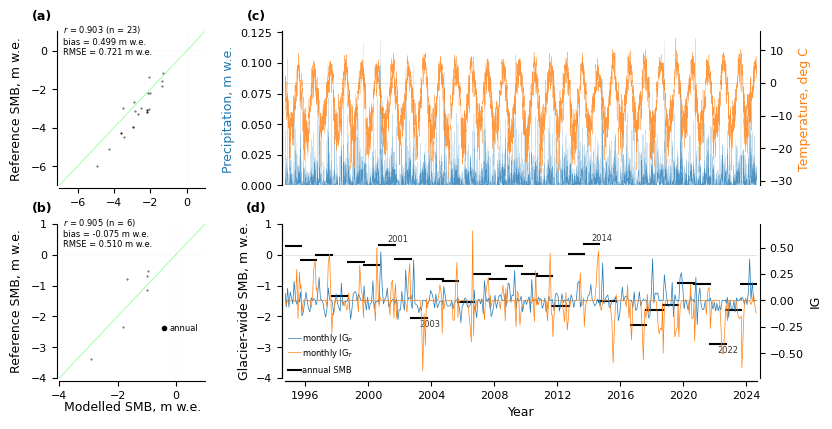

In [29]:
fig = plt.figure(figsize=(9, 4.5))

# Outer 2x4 grid
gs = fig.add_gridspec(2, 4, width_ratios=[1.4, 1, 1, 1], wspace=0.7, hspace=0.25)
gs_sub = gs[:, 1:].subgridspec(2, 1, wspace=0, hspace=0.25)

# Left: 2 axes
ax_l1 = fig.add_subplot(gs[0, 0])
ax_l2 = fig.add_subplot(gs[1, 0])

# Long hor axes
ax_daily_p = fig.add_subplot(gs_sub[0])
ax_daily_t = ax_daily_p.twinx()
ax_smb = fig.add_subplot(gs_sub[1])
ax_ig = ax_smb.twinx()
for ax in [ax_daily_t, ax_daily_p]:
    ax.set_rasterized(True)


def make_scatter(ax, glacier, estimation_type, start_year=2019, end_year=2025, alpha_factor=2):
    # read x, y
    true_pred = {s: {"true": [], "pred": []} for s in ["annual", "winter", "summer"]}
    eval_path = f"eval/a_finetuned/{glacier['name']}.json"
    with open(eval_path, "r") as src:
        evaluation = json.load(src)
    for year in range(start_year, end_year):
        for s in ["annual", "winter", "summer"]:
            if str(year) in evaluation["true_pred"][estimation_type]["per_year"][s].keys():
                true_pred[s]["true"].extend(evaluation["true_pred"][estimation_type]["per_year"][s][str(year)]["true"])
                true_pred[s]["pred"].extend(evaluation["true_pred"][estimation_type]["per_year"][s][str(year)]["pred"])
    # make plot and labels
    # annual
    true, pred = np.array(true_pred["annual"]["true"]), np.array(true_pred["annual"]["pred"])
    if len(true) > 2:
        ax.scatter(pred, true, color="black", alpha=min(0.4 * alpha_factor, 1.0), zorder=-5, s=0.15, label="annual")
        r, _ = scipy.stats.pearsonr(pred, true)
        rmse = np.sqrt(np.mean((pred - true)**2))
        bias = np.mean(pred - true)
        report = f"$r$ = {r:.3f} (n = {len(true)}) \nbias = {bias:.3f} m w.e. \nRMSE = {rmse:.3f} m w.e."
        ax.text(0.025, 1.05, report, ha="left", va="top", transform=ax.transAxes, size=6, color="black", zorder=10)
    # winter
    true, pred = np.array(true_pred["winter"]["true"]), np.array(true_pred["winter"]["pred"])
    if len(true) > 2:
        ax.scatter(pred, true, color="C0", alpha=min(0.4 * alpha_factor, 1.0), zorder=-3, s=0.15, label="winter")
        r, _ = scipy.stats.pearsonr(pred, true)
        rmse = np.sqrt(np.mean((pred - true)**2))
        bias = np.mean(pred - true)
        report = f"$r$ = {r:.3f} (n = {len(true)}) \nbias = {bias:.3f} m w.e. \nRMSE = {rmse:.3f} m w.e."
        ax.text(0.45, 0.20, report, ha="left", va="top", transform=ax.transAxes, size=6, color="C0", zorder=10)
    # summer
    true, pred = np.array(true_pred["summer"]["true"]), np.array(true_pred["summer"]["pred"])
    if len(true) > 2:
        ax.scatter(pred, true, color="C1", alpha=min(0.6 * alpha_factor, 1.0), zorder=-4, s=0.15, label="summer")
        r, _ = scipy.stats.pearsonr(pred, true)
        rmse = np.sqrt(np.mean((pred - true)**2))
        bias = np.mean(pred - true)
        report = f"$r$ = {r:.3f} (n = {len(true)}) \nbias = {bias:.3f} m w.e. \nRMSE = {rmse:.3f} m w.e."
        ax.text(0.025, 0.82, report, ha="left", va="top", transform=ax.transAxes, size=6, color="C1", zorder=10)
        

make_scatter(ax_l1, glacier, "point")
make_scatter(ax_l2, glacier, "glacier-wide")


time_vals = glacier_t["time"].values
ax_daily_p.plot(time_vals, glacier_p, color="C0", linewidth=0.1, alpha=0.8)
ax_daily_t.plot(time_vals, glacier_t, color="C1", linewidth=0.25, alpha=0.8)

smb_xs = np.concatenate([[yr1, yr2, 0] for yr1, yr2 in year_bins])
smb_ys = np.concatenate([[smb, smb, np.nan] for smb in smb_results])
ax_smb.plot(smb_xs, smb_ys, color="black", linewidth=1.5, label="annual SMB", zorder=5)
ax_ig.plot(glacier_ig_p["time"].values, glacier_ig_p, color="C0", linewidth=0.5, label="monthly IG$_P$", zorder=-5)
ax_ig.plot(glacier_ig_t["time"].values, glacier_ig_t, color="C1", linewidth=0.5, label="monthly IG$_T$", zorder=-5)
for yr_lbl in label_years:
    yr_idx = yr_lbl - constants.study_period_start_year
    x = np.mean(np.array(year_bins[yr_idx]).astype(int)).astype(year_bins[yr_idx][0].dtype)
    y, pad = smb_results[yr_idx], 0.05
    ax_smb.text(
        x, y + (pad if y > 0 else -pad), 
        str(yr_lbl), 
        va="bottom" if y > 0 else "top", ha="center",
        size=6, color="black", alpha=0.8, 
    )

# labels and style
for ax in [ax_l1, ax_l2]:
    ax.text(-0.25, 0.5, "Reference SMB, m w.e.", ha="right", va="center", transform=ax.transAxes, size=9, rotation="vertical")
ax_l2.text(0.5, -0.15, "Modelled SMB, m w.e.", ha="center", va="top", transform=ax_l2.transAxes, size=9)

ax_smb.set_xlabel("Year", size=9)
ax_smb.set_ylabel("Glacier-wide SMB, m w.e.", size=9)
ax_ig.set_ylabel("IG", size=9)
ax_daily_p.set_ylabel("Precipitation, m w.e.", color="C0", size=9)
ax_daily_t.set_ylabel("Temperature, deg C", color="C1", size=9)

for i_ax, ax in enumerate([ax_l1, ax_l2, ax_daily_p, ax_daily_t, ax_smb, ax_ig]):
    ax.spines["top"].set_visible(False)
    if i_ax not in {3, 5}:
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["right"].set_position(("outward", 2))
    ax.spines["left"].set_position(("outward", 2))
    if i_ax not in {2, 3}:
        ax.spines["bottom"].set_position(("outward", 2))
    else:
        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([])

for ax in [ax_l1, ax_l2]:
    ax.axline((0, 0), slope=1, color=[0.0, 1.0, 0.0, 0.5], zorder=-10, linewidth=0.5)
    ax.axvline(0, color=[0.0, 0.0, 0.0, 0.15], zorder=-15, linewidth=0.1)
    ax.axhline(0, color=[0.0, 0.0, 0.0, 0.15], zorder=-15, linewidth=0.1)
for ax in [ax_daily_t, ax_smb, ax_ig]:
    ax.axhline(0, color=[0.0, 0.0, 0.0, 0.15], zorder=-15, linewidth=0.5)

ax_l1.set_xlim(-7, 1)
ax_l1.set_ylim(-7, 1)
ax_l2.set_xlim(-4, 1)
ax_l2.set_ylim(-4, 1)
ax_smb.set_ylim(-4, 1)
for ax in [ax_smb, ax_daily_t, ax_daily_p]:
    ax.set_xlim(time_vals[0], time_vals[-1])
ax_daily_p.set_ylim(0.0)

for ax in [ax_l1, ax_l2, ax_smb, ax_ig, ax_daily_t, ax_daily_p]:
    ax.tick_params(axis="both", labelsize=8)
for i_ax, ax in enumerate([ax_l1, ax_l2, ax_daily_p, ax_smb]):
    panel_label = f"({chr(ord('a') + i_ax)})"
    x, y = (-0.12, 1.1) if i_ax in {0, 1} else (-0.060, 1.1)
    ax.text(x, y, panel_label, weight="bold", ha="center", va="center", transform=ax.transAxes, size=9)

legend_handles = [matplotlib.lines.Line2D(
    [], [], 
    marker="o", 
    color=c, 
    linestyle="none",
    markersize=3,
    markerfacecolor=c,
    alpha=1.0,
) for c in ["black"]]
ax_l2.legend(handles=legend_handles, labels=["annual"], handletextpad=0.0, handlelength=1.5, labelspacing=0.2, frameon=False, fontsize=6, loc=(0.65, 0.27))
ax_smb.legend(loc=(0.0, 0.00), handletextpad=0.2, handlelength=1.5, labelspacing=0.2, frameon=False, fancybox=False, fontsize=6)
ax_ig.legend(loc=(0.0, 0.10), handletextpad=0.2, handlelength=1.5, labelspacing=0.2, frameon=False, fancybox=False, fontsize=6)

plt.savefig(f"figures/xai.pdf", dpi=300, bbox_inches="tight", pad_inches=0.02)
plt.show()